In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

El encoder por defecto no puede decodificar algún caracter raro así que usuaré otro encoder

In [103]:
df = pd.read_csv('recieved_dirty_dataset.csv', encoding='latin-1')

In [104]:
df.head()

,ID_REGISTRO_X,date_,price,bedrooms,BATH,sqft_living,yr_built,condition
0,7527200030,20141229T000000,700000.0,5.0,2.50,2830.0,1979,5
1,3300701615,20140930T000000,655000.0,50.0,2.50,NaN,2002,3
2,9528102996,20141207T000000,549000.0,3.0,1.75,1540.0,2014,3
3,2008200060,20140624T000000,160000.0,3.0,1.50,1010.0,1962,Fouur
4,3394100030,20140909T000000,975000.0,4.0,2.50,2720.0,1989,3


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID_REGISTRO_X  600 non-null    int64  
 1   date_          600 non-null    object 
 2   price          569 non-null    object 
 3   bedrooms       597 non-null    float64
 4   BATH           595 non-null    float64
 5   sqft_living    537 non-null    float64
 6   yr_built       600 non-null    object 
 7   condition      600 non-null    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 37.6+ KB


En primer lugar me fijo en que las columnas tienen nombres no estandarizados, así que es lo primero que voy a corregir

In [106]:
df = df.rename(columns={
    'ID_REGISTRO_X': 'id',
    'date_': 'date',
    'BATH': 'bathrooms'
})

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,yr_built,condition
0,7527200030,20141229T000000,700000.0,5.0,2.50,2830.0,1979,5
1,3300701615,20140930T000000,655000.0,50.0,2.50,NaN,2002,3
2,9528102996,20141207T000000,549000.0,3.0,1.75,1540.0,2014,3
3,2008200060,20140624T000000,160000.0,3.0,1.50,1010.0,1962,Fouur
4,3394100030,20140909T000000,975000.0,4.0,2.50,2720.0,1989,3


Lo siguiente que se me ocurre es revisar si hay duplicados y eliminarlos

In [107]:
duplicados = df.duplicated().sum()
print(f'{duplicados} duplicados y {df.shape[0]} filas en total')

51 duplicados y 600 filas en total


In [108]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f'{df.shape[0]} filas en total')

549 filas en total


## COLUMNA ID

Parece que la columna id se salva, vamos a checkear por si acaso que no tenga nulos antes de pasar a la siguiente

In [109]:
df['id'].isna().sum()

np.int64(0)

Vemos que está bien así que vamos con la columna date

## COLUMNA DATE

In [110]:
df['date'].head()

0    20141229T000000
1    20140930T000000
2    20141207T000000
3    20140624T000000
4    20140909T000000
Name: date, dtype: object

Los primeros registros vemos que siguen un patrón de formato determinado, vamos a identificarlos

In [111]:
df['date'] = df['date'].astype(str)

df['date_temporal'] = pd.to_datetime(
    df['date'].str.replace('T000000', ''),
    format='%Y%m%d',
    errors='coerce' # Convierte valores no válidos a NaT
)

# Filtrar las filas donde la conversión falló (es decir, donde el valor es NaT)
anomalous_dates = df[df['date_temporal'].isnull()]


anomalous_counts = anomalous_dates['date'].value_counts()
print(anomalous_counts)   

del df['date_temporal']

date
ERROR-Aï¿½o-ï¿½0000    6
Name: count, dtype: int64


Los valores anómalos son los ERROR-Año-Ñ0000 que convertiremos a NaT para posteriormente eliminarlos

In [112]:
df['date'] = df['date'].replace('ERROR-Año-Ñ0000', np.nan)
df['date'] = df['date'].str.replace('T000000', '', regex=False)

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')

rows_before = len(df)
df.dropna(subset=['date'], inplace=True)
rows_after = len(df)

print(f"Filas eliminadas debido a NaT: {rows_before - rows_after}")
print(f"Nulos (NaT) finales en 'date': {df['date'].isnull().sum()}")

Filas eliminadas debido a NaT: 6
Nulos (NaT) finales en 'date': 0


In [113]:
df['date'].head()

0   2014-12-29
1   2014-09-30
2   2014-12-07
3   2014-06-24
4   2014-09-09
Name: date, dtype: datetime64[ns]

## COLUMNA PRICE

In [114]:
df['price_str'] = df['price'].astype(str)

# Intentamos convertir la versión string a numérico, forzando errores a NaN
df['price_test'] = pd.to_numeric(df['price_str'], errors='coerce')

# Filtramos las filas donde la conversión a numérico falló (NaN)
anomalous_prices = df[df['price_test'].isnull()]

# Si hay valores anómalos, mostramos los 20 más frecuentes
if not anomalous_prices.empty:
    # Contamos la frecuencia de los valores anómalos originales
    anomalous_counts = anomalous_prices['price_str'].value_counts()
    
    # Imprimimos los 20 valores más frecuentes para ver qué caracteres están causando problemas
    print(anomalous_counts.head(20))
    
else:
    print("No se detectaron valores de texto que impidan la conversión a número.")

# Limpieza de las columnas temporales de testeo
del df['price_str']
del df['price_test']

price_str
nan           25
230000 EUR     3
605000 EUR     2
245000 EUR     2
550000 EUR     2
330000 EUR     2
425000 EUR     2
325000 EUR     2
780000 EUR     1
240000 EUR     1
465000 EUR     1
653000 EUR     1
650000 EUR     1
340000 EUR     1
275000 EUR     1
480000 EUR     1
199000 EUR     1
715000 EUR     1
397000 EUR     1
610000 EUR     1
Name: count, dtype: int64


Quitamos los EUR y espacios que puedan haber

In [115]:
df['price'] = df['price'].astype(str) 
df['price'] = df['price'].str.replace('EUR', '', regex=False)
df['price'] = df['price'].str.strip() 
df['price'] = pd.to_numeric(df['price'], errors='coerce')

La mediana es utilizada para la imputación porque es la medida más robusta contra los valores atípicos (outliers) y la asimetría de los datos (común en precios), a diferencia de la media.

In [116]:
median_price = df['price'].median()
df['price'].fillna(median_price, inplace=True)

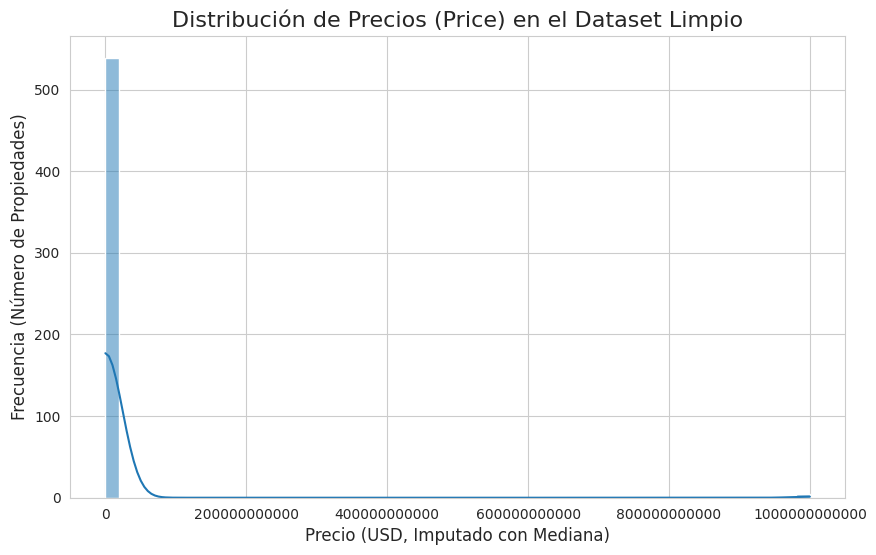

In [117]:
# Configurar el estilo para una mejor visualización
sns.set_style("whitegrid")

# 1. Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# 2. Generar el histograma de la columna price
# 'kde=True' añade una estimación de densidad del núcleo, mostrando la forma general de la distribución.
# 'bins=50' utiliza 50 barras para una visualización más detallada de la distribución.
sns.histplot(df['price'], bins=50, kde=True)

# 3. Añadir títulos y etiquetas para claridad
plt.title('Distribución de Precios (Price) en el Dataset Limpio', fontsize=16)
plt.xlabel('Precio (USD, Imputado con Mediana)', fontsize=12)
plt.ylabel('Frecuencia (Número de Propiedades)', fontsize=12)

# Formatear el eje X para que los precios sean legibles
plt.ticklabel_format(style='plain', axis='x') # Evita la notación científica

plt.show()

Parece que se me han colado algunos outliers así que los voy a eliminar

In [118]:
# 1. Cuantificar el IQR
Q1_price = df['price'].quantile(0.25)
Q3_price = df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# 2. Definir el Límite Superior de Outlier (Frontera)
# Las propiedades por encima de este límite serán eliminadas
upper_limit_price = Q3_price + 1.5 * IQR_price

# 3. Contar las filas a eliminar
rows_to_remove = df[df['price'] > upper_limit_price].shape[0]
rows_before = len(df)

# 4. FILTRAR Y ELIMINAR: Sobreescribir el DataFrame sin los outliers
df = df[df['price'] <= upper_limit_price]

# 5. Verificación de Resultados
rows_after = len(df)
print(f"--- Eliminación de Outliers en price (Método IQR) ---")
print(f"Límite Superior de Eliminación: {upper_limit_price:,.2f}")
print(f"Filas eliminadas (Outliers): {rows_to_remove}")
print(f"Porcentaje de datos eliminados: {(rows_to_remove / rows_before) * 100:.2f}%")
print(f"Filas restantes en el dataset: {rows_after}")

--- Eliminación de Outliers en price (Método IQR) ---
Límite Superior de Eliminación: 1,065,375.00
Filas eliminadas (Outliers): 27
Porcentaje de datos eliminados: 4.97%
Filas restantes en el dataset: 516


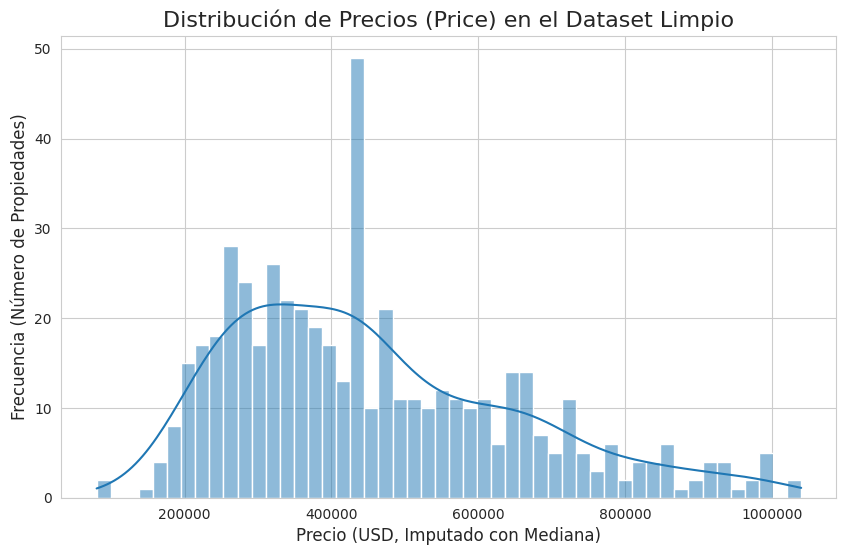

In [119]:
# Configurar el estilo para una mejor visualización
sns.set_style("whitegrid")

# 1. Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# 2. Generar el histograma de la columna price
# 'kde=True' añade una estimación de densidad del núcleo, mostrando la forma general de la distribución.
# 'bins=50' utiliza 50 barras para una visualización más detallada de la distribución.
sns.histplot(df['price'], bins=50, kde=True)

# 3. Añadir títulos y etiquetas para claridad
plt.title('Distribución de Precios (Price) en el Dataset Limpio', fontsize=16)
plt.xlabel('Precio (USD, Imputado con Mediana)', fontsize=12)
plt.ylabel('Frecuencia (Número de Propiedades)', fontsize=12)


plt.ticklabel_format(style='plain', axis='x')

plt.show()

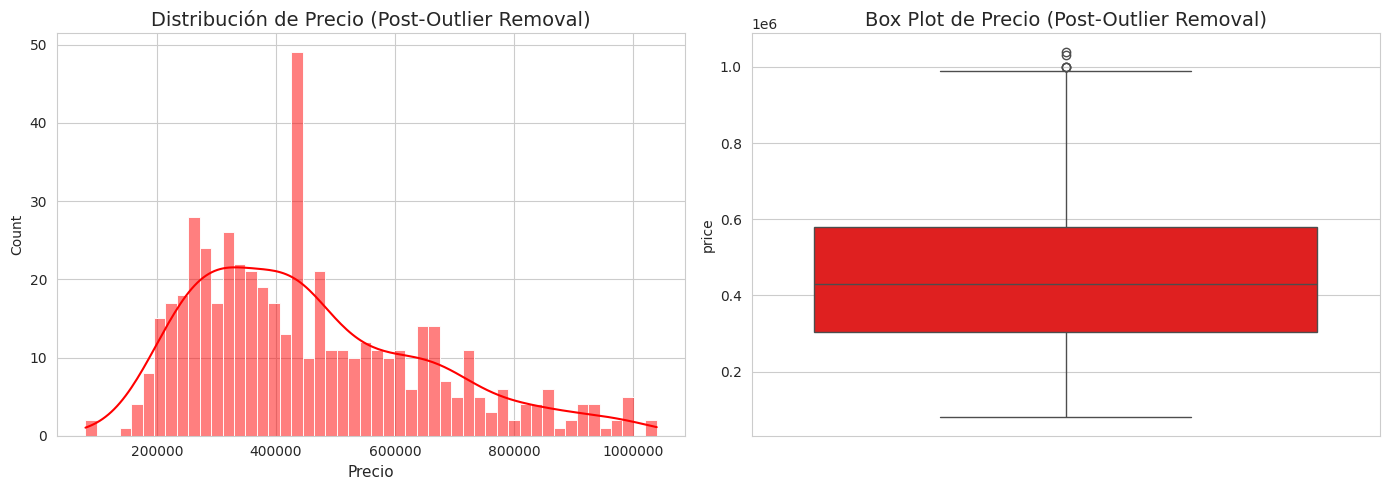

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# Histograma después de la eliminación
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True, color='red')
plt.title('Distribución de Precio (Post-Outlier Removal)', fontsize=14)
plt.xlabel('Precio', fontsize=11)
plt.ticklabel_format(style='plain', axis='x')

# Box Plot después de la eliminación (debería tener muy pocos o ningún outlier)
plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'], color='red')
plt.title('Box Plot de Precio (Post-Outlier Removal)', fontsize=14)

plt.tight_layout()
plt.show()

## COLUMNA BEDROOMS

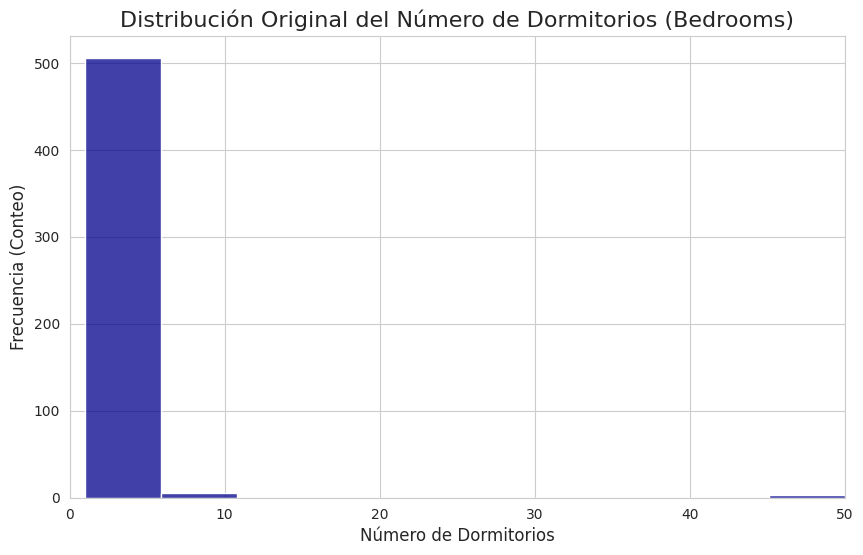

In [121]:
# Aseguramos que la columna sea numérica para el histograma, convirtiendo errores a NaN
bedrooms_temp = pd.to_numeric(df['bedrooms'], errors='coerce') 

# Configurar el estilo
sns.set_style("whitegrid")

# 1. Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# 2. Generar el histograma de la columna bedrooms
sns.histplot(bedrooms_temp, bins=10, kde=False, color='darkblue')

# 3. Añadir títulos y etiquetas
plt.title('Distribución Original del Número de Dormitorios (Bedrooms)', fontsize=16)
plt.xlabel('Número de Dormitorios', fontsize=12)
plt.ylabel('Frecuencia (Conteo)', fontsize=12)

# Establecer límites del eje x para asegurar que se vea el outlier 50
plt.xlim(0, max(bedrooms_temp.dropna().max(), 10)) # Muestra hasta el valor más alto o 10

plt.show()

In [122]:
df['bedrooms'].replace(50, np.nan, inplace=True)

df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce', downcast='integer') 

median_bedrooms = df['bedrooms'].median()
df['bedrooms'].fillna(median_bedrooms, inplace=True)

df['bedrooms'] = df['bedrooms'].astype(int)

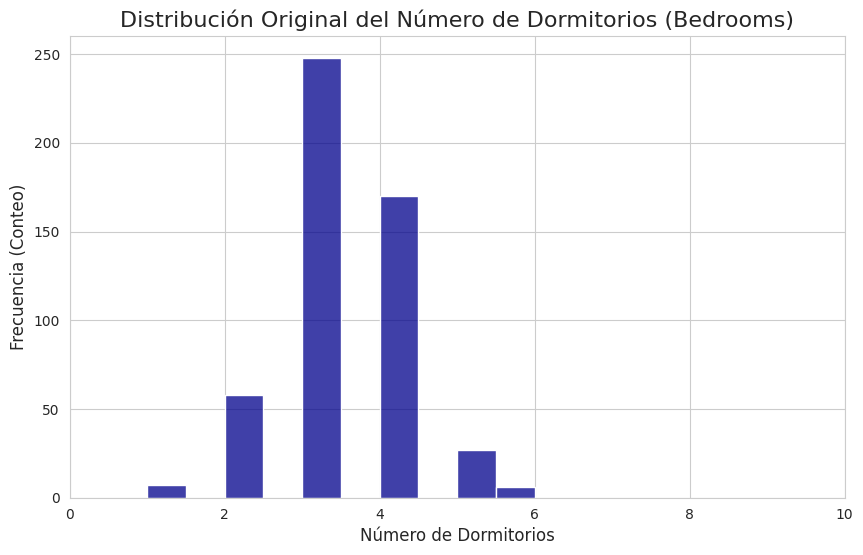

In [123]:
# Aseguramos que la columna sea numérica para el histograma, convirtiendo errores a NaN
bedrooms_temp = pd.to_numeric(df['bedrooms'], errors='coerce') 

# Configurar el estilo
sns.set_style("whitegrid")

# 1. Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# 2. Generar el histograma de la columna bedrooms
sns.histplot(bedrooms_temp, bins=10, kde=False, color='darkblue')

# 3. Añadir títulos y etiquetas
plt.title('Distribución Original del Número de Dormitorios (Bedrooms)', fontsize=16)
plt.xlabel('Número de Dormitorios', fontsize=12)
plt.ylabel('Frecuencia (Conteo)', fontsize=12)

# Establecer límites del eje x para asegurar que se vea el outlier 50
plt.xlim(0, max(bedrooms_temp.dropna().max(), 10)) # Muestra hasta el valor más alto o 10

plt.show()

## COLUMNA BATHROOMS

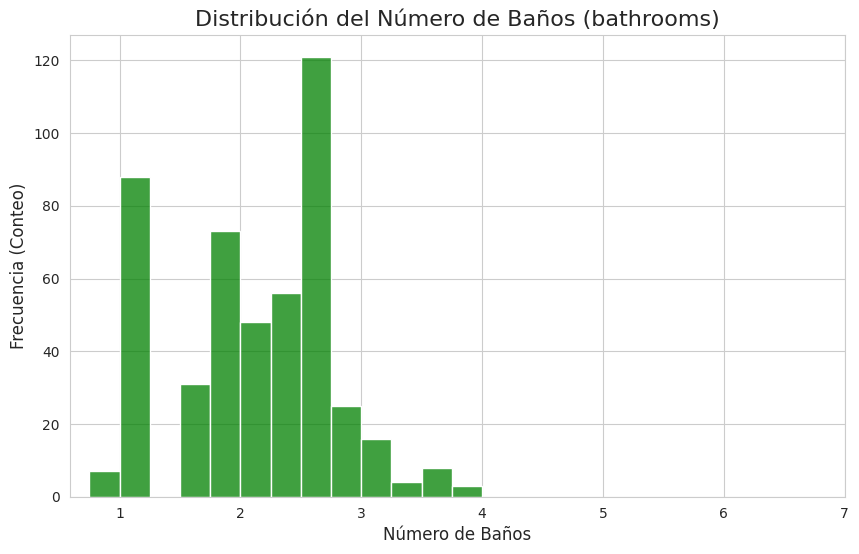

In [ ]:
bathrooms_temp = pd.to_numeric(df['bathrooms'], errors='coerce') 

# Configurar el estilo
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
# Usamos bins enteros ya que los baños suelen ser 1, 1.5, 2, 2.5, etc.
sns.histplot(bathrooms_temp.dropna(), bins=np.arange(0.5, 8.5, 0.5), kde=False, color='green')

plt.title('Distribución del Número de Baños (bathrooms)', fontsize=16)
plt.xlabel('Número de Baños', fontsize=12)
plt.ylabel('Frecuencia (Conteo)', fontsize=12)
plt.xticks(np.arange(1, 8, 1)) # Marcamos solo los números enteros en el eje X
plt.show()

## COLUMNA SQFT LIVING

In [125]:
df['sqft_living'] = pd.to_numeric(df['sqft_living'], errors='coerce') 
print(f"Nulos (NaN) iniciales detectados: {df['sqft_living'].isnull().sum()}")
print(f"Valor máximo actual: {df['sqft_living'].max():,.0f}")

Nulos (NaN) iniciales detectados: 55
Valor máximo actual: 4,870


In [126]:
median_sqft = df['sqft_living'].median()
df['sqft_living'].fillna(median_sqft, inplace=True)

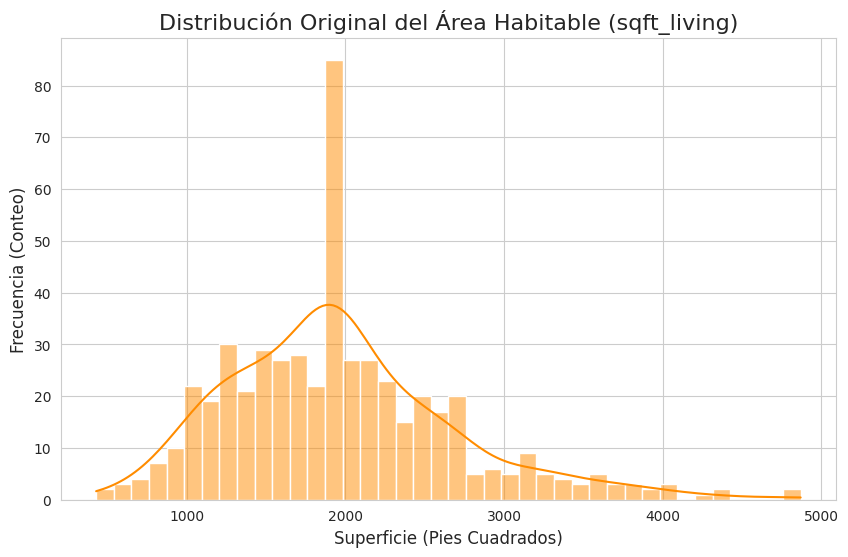

In [127]:
# Convertimos la columna a numérica (los 'NaN' introducidos se manejan bien)
sqft_living_temp = pd.to_numeric(df['sqft_living'], errors='coerce') 

# Configurar el estilo
sns.set_style("whitegrid")

# 1. Crear la figura
plt.figure(figsize=(10, 6))

# 2. Generar el histograma. Usamos bins ajustados para ver la distribución normal
sns.histplot(sqft_living_temp.dropna(), bins=40, kde=True, color='darkorange')

# 3. Añadir títulos y etiquetas
plt.title('Distribución Original del Área Habitable (sqft_living)', fontsize=16)
plt.xlabel('Superficie (Pies Cuadrados)', fontsize=12)
plt.ylabel('Frecuencia (Conteo)', fontsize=12)

plt.show()


## YR BUILT

In [128]:
df['yr_built'] = pd.to_numeric(df['yr_built'], errors='coerce')
print(f"Nulos (NaN) iniciales detectados: {df['yr_built'].isnull().sum()}")
print(f"Año Mínimo detectado: {df['yr_built'].min()}")
print(f"Año Máximo detectado: {df['yr_built'].max()}")

Nulos (NaN) iniciales detectados: 28
Año Mínimo detectado: 1700.0
Año Máximo detectado: 2050.0


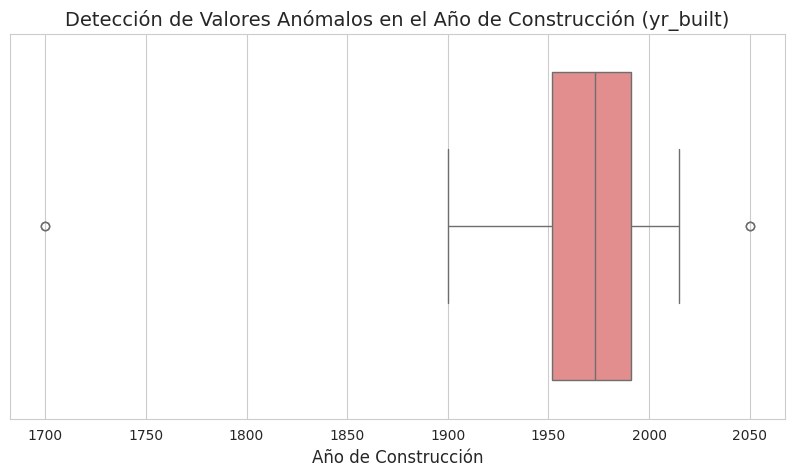

In [129]:
yr_built_temp = pd.to_numeric(df['yr_built'], errors='coerce').dropna()

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

# Generar el Box Plot
sns.boxplot(x=yr_built_temp, color='lightcoral')

plt.title('Detección de Valores Anómalos en el Año de Construcción (yr_built)', fontsize=14)
plt.xlabel('Año de Construcción', fontsize=12)

plt.show()

En esta columna si que opto por eliminar los valores nulos porque considero que errores en el año de construcción afectan a otras columnas debido a la inflacción así que pueden distorsionar el dataset

In [130]:
# 1. CONVERSIÓN Y NEUTRALIZACIÓN DE ERRORES A NaN
# Aseguramos la columna a numérica y convertimos cualquier string a NaN.
df['yr_built'] = pd.to_numeric(df['yr_built'], errors='coerce') 

# 2. Neutralización de Outliers Específicos
# Los valores 1700 y 2050 se convierten explícitamente a NaN para que sean eliminados.
outliers_to_replace = [1700, 2050]
rows_impacted_neutralization = df[df['yr_built'].isin(outliers_to_replace)].shape[0]
df['yr_built'].replace(outliers_to_replace, np.nan, inplace=True)

print(f"Outliers específicos (1700, 2050) y strings de error convertidos a NaN.")

# 3. ELIMINACIÓN DE FILAS (Listwise Deletion)
rows_before_drop = df.shape[0]
# Eliminamos todas las filas donde 'yr_built' sea NaN.
df.dropna(subset=['yr_built'], inplace=True)
rows_after_drop = df.shape[0]
rows_dropped_total = rows_before_drop - rows_after_drop

print(f"\nResultado de la Eliminación:")
print(f"Filas eliminadas debido a nulos/errores en yr_built: {rows_dropped_total}")
print(f"Filas restantes en el DataFrame: {rows_after_drop}")

# 4. CONVERSIÓN DE TIPO FINAL
df['yr_built'] = df['yr_built'].astype(int)

print(f"Nulos finales en yr_built: {df['yr_built'].isnull().sum()}")
print(f"Tipo de dato final: {df['yr_built'].dtype}")

Outliers específicos (1700, 2050) y strings de error convertidos a NaN.

Resultado de la Eliminación:
Filas eliminadas debido a nulos/errores en yr_built: 32
Filas restantes en el DataFrame: 484
Nulos finales en yr_built: 0
Tipo de dato final: int64


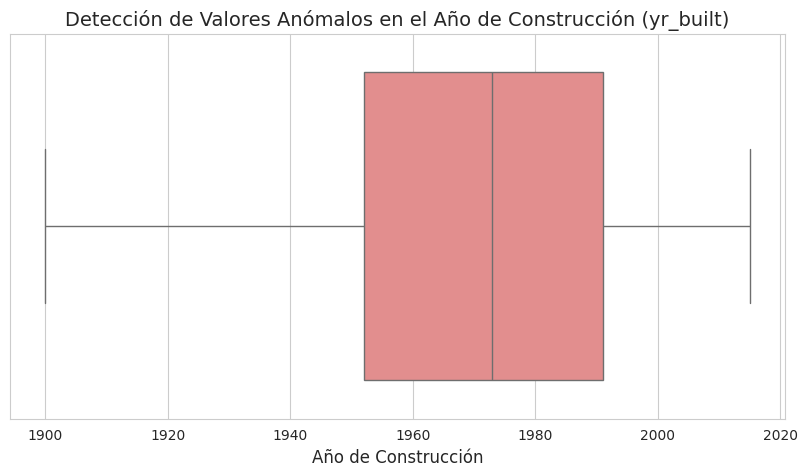

In [131]:
yr_built_temp = pd.to_numeric(df['yr_built'], errors='coerce').dropna()

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

# Generar el Box Plot
sns.boxplot(x=yr_built_temp, color='lightcoral')

plt.title('Detección de Valores Anómalos en el Año de Construcción (yr_built)', fontsize=14)
plt.xlabel('Año de Construcción', fontsize=12)

plt.show()

## COLUMNA CONDITION

Por lo que se ve esta columna es una especie de enum así que voy a revisar los valores

In [132]:
print("Conteo de valores en 'condition' antes de la limpieza:")
print(df['condition'].value_counts(dropna=False)) 

Conteo de valores en 'condition' antes de la limpieza:
condition
3            270
Fouur        138
5             40
ZOMBIE        11
999           10
NA_JUNK        7
ERROR_MAP      4
2              3
1              1
Name: count, dtype: int64


In [133]:
df['condition'].replace('Fouur', 4, inplace=True)
df['condition'] = pd.to_numeric(df['condition'], errors='coerce')
df['condition'].replace(999, np.nan, inplace=True)
df['condition'].fillna(df['condition'].mode()[0], inplace=True)

In [134]:
df.to_csv('clean_dataset.csv', index=False)

In [136]:
df_clean = pd.read_csv('clean_dataset.csv')

In [138]:
df_clean.describe()

,id,price,bedrooms,bathrooms,sqft_living,yr_built,condition
count,4.840000e+02,4.840000e+02,484.000000,480.000000,484.000000,484.000000,484.000000
mean,4.483482e+09,4.534944e+05,3.324380,2.003646,1955.648760,1968.861570,3.440083
std,2.954140e+09,1.950286e+05,0.851344,0.664184,722.616193,27.683576,0.661359
min,1.151031e+07,8.000000e+04,1.000000,0.750000,430.000000,1900.000000,1.000000
25%,1.868075e+09,3.050000e+05,3.000000,1.500000,1447.500000,1952.000000,3.000000
50%,3.767650e+09,4.300000e+05,3.000000,2.000000,1900.000000,1973.000000,3.000000
75%,7.390750e+09,5.762500e+05,4.000000,2.500000,2300.000000,1991.000000,4.000000
max,9.828703e+09,1.040000e+06,6.000000,4.000000,4870.000000,2015.000000,5.000000


In [ ]:
numerical_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'yr_built']

print(df_clean[numerical_cols].describe())

              price    bedrooms   bathrooms  sqft_living     yr_built
count  4.840000e+02  484.000000  480.000000   484.000000   484.000000
mean   4.534944e+05    3.324380    2.003646  1955.648760  1968.861570
std    1.950286e+05    0.851344    0.664184   722.616193    27.683576
min    8.000000e+04    1.000000    0.750000   430.000000  1900.000000
25%    3.050000e+05    3.000000    1.500000  1447.500000  1952.000000
50%    4.300000e+05    3.000000    2.000000  1900.000000  1973.000000
75%    5.762500e+05    4.000000    2.500000  2300.000000  1991.000000
max    1.040000e+06    6.000000    4.000000  4870.000000  2015.000000
      price  bedrooms  bathrooms  sqft_living  yr_built
0  430000.0         3        2.5       1900.0      2005


In [145]:
print(df_clean[numerical_cols].mode().head(1)) 

      price  bedrooms  bathrooms  sqft_living  yr_built
0  430000.0         3        2.5       1900.0      2005


## Informe de Limpieza

Este informe documenta el proceso de transformación de un conjunto de datos de su estado inicial (sucio) a un estado final (limpio), listo para un análisis exploratorio de datos. El objetivo principal fue abordar problemas de encoding, inconsistencias de formato, valores atípicos (outliers) y valores faltantes para garantizar la integridad y fiabilidad de los datos.

El proceso de limpieza se ejecutó en una serie de pasos secuenciales para estandarizar la estructura y corregir la calidad de los datos.

1. Carga y Solución del Problema de Encoding

Problema: Al cargar el archivo recieved_dirty_dataset.csv, se encontró un error de decodificación debido a caracteres especiales.


Solución: Se especificó el parámetro encoding='latin-1' en la función pd.read_csv() para permitir una carga exitosa del archivo.

2. Estandarización Estructural

Problema: Los nombres de las columnas presentaban inconsistencias (mayúsculas, snake_case incompleto).

Solución:

Se estandarizaron los nombres de las columnas al formato snake_case (ej. BATH a bathrooms, date_ a date) para mejorar la legibilidad del código.

3. Conversión de Tipos de Datos (date)

Problema: La columna date estaba en formato de cadena de texto largo (YYYYMMDDThhmmss00), impidiendo el análisis temporal.

Solución: La columna se limpió extrayendo solo la porción YYYYMMDD y luego se convirtió al tipo datetime de Pandas.

4. Manejo de Inconsistencias Categóricas (condition)

Problema: La columna ordinal condition (que califica el estado de la casa de 1 a 5) contenía valores textuales y erróneos como 'Fouur', 'ZOMBIE', y valores nulos.

Solución:

Se mapearon las inconsistencias: 'Fouur' se corrigió a '4' y los valores sin sentido ('ZOMBIE') se reemplazaron por NaN.

Los valores NaN generados y los preexistentes se imputaron utilizando la moda de la columna.

Finalmente, la columna se convirtió al tipo entero (int).

5. Tratamiento de Outliers y Valores Faltantes

Problema A (Outlier): Se detectó un valor atípico en bedrooms de 50, lo cual es físicamente irreal para una propiedad residencial estándar.

Problema B (Valores Faltantes): Existían valores faltantes en bedrooms y sqft_living.

Solución:

El valor outlier de 50 en bedrooms se reemplazó por NaN.

Los valores NaN de bedrooms y sqft_living se imputaron utilizando la mediana, una medida más robusta frente a la posible presencia de otros outliers o distribuciones sesgadas.